In [1]:
import numpy as np
from source.Files_operating import read_sht_data

shtRipper v1.3


In [85]:
import time
import copy
import random

from matplotlib.colors import CSS4_COLORS as COLORS

In [3]:
def get_boarders(data: np.array, loc_max_ind=None, scale=1.5):
    loc_max_ind = np.argmax(data)
    dist_ind = np.argsort(np.abs(data - data[loc_max_ind] / scale))
    return Slice(dist_ind[dist_ind <= loc_max_ind][0], dist_ind[dist_ind >= loc_max_ind][0])


class Slice:
    def __init__(self, start_index=0, end_index=0):
        self.l = start_index
        self.r = end_index
        self.mark = 1.0

    def set_boarders(self, start_index: int, end_index: int) -> None:
        self.l = start_index
        self.r = end_index

    def set_mark(self, mark: int) -> None:
        self.mark = mark

    def copy(self):
        new_slice = Slice(self.l, self.r)
        new_slice.set_mark(new_slice.mark)
        return new_slice

    def check_length(self, len_edge: int) -> bool:
        return self.r - self.l > len_edge

    def check_dist(self, other, dist_edge: int) -> bool:
        return other.l - self.r > dist_edge

    def collide_slices(self, other, dist_edge: int) -> bool:
        if not self.check_dist(other, dist_edge):
            self.r = other.r
            return True
        return False

    def step(self) -> None:
        self.r += 1

    def move(self, delta: int) -> None:
        self.r += delta
        self.l += delta

    def expand(self, delta: int) -> None:
        self.r += delta
        self.l -= delta

    def collapse_boarders(self) -> None:
        self.l = self.r

    def is_null(self) -> bool:
        return self.l == self.r

    def __repr__(self):
        return f"({self.l}, {self.r})"


class Signal_meta:
    def __init__(self, chanel_name="da", processing_flag=False, 
                 quantile_edge=0.0, std_edge=1.0, 
                 length_edge=10, distance_edge=10, scale=1.5, step_out=10, 
                 std_bottom_edge=0, std_top_edge=1, d_std_bottom_edge=3, d_std_top_edge=6, amplitude_ratio=0.5):
        self.name = chanel_name
        self.proc_fl = processing_flag
        
        self.len_edge = length_edge
        self.dist_edge = distance_edge
        self.scale = scale
        self.step_out = step_out
        
        self.q = quantile_edge
        self.std = std_edge
        
        self.d_q = quantile_edge
        self.d_std = std_edge

        self.std_top = std_top_edge
        self.std_bottom = std_bottom_edge
        self.d_std_top = d_std_top_edge
        self.d_std_bottom = d_std_bottom_edge

        self.max_min_ratio = amplitude_ratio
        
    def set_statistics(self, data: np.array, data_diff: np.array, percentile: float, d_percentile: float, std_bottom_edge=0, std_top_edge=1, d_std_bottom_edge=3, d_std_top_edge=6, amplitude_ratio=0.5):
        self.q = np.quantile(data, percentile)
        self.std = data.std()
        self.std_top = std_top_edge
        self.std_bottom = std_bottom_edge
        
        self.d_q = np.quantile(data_diff, percentile)
        self.d_std = data_diff.std()
        if self.name == "sxr":
            a = 10.5
            b = -850
            self.d_std_top = d_std_top_edge / d_std_bottom_edge * a * np.exp(b * self.d_std)
            self.d_std_bottom = a * np.exp(b * self.d_std)
        else:
            self.d_std_top = d_std_top_edge
            self.d_std_bottom = d_std_bottom_edge            

        self.max_min_ratio = amplitude_ratio

    def set_edges(self, length_edge=10, distance_edge=10, scale=1.5, step_out=10):
        self.len_edge = length_edge
        self.dist_edge = distance_edge
        self.scale = scale
        self.step_out = step_out


def get_peaks(data: np.array, s_i: int) -> np.array:
    peaks_ind = []
    loc_max = data.min()
    m_v = data.mean()
    loc_max_ind = 0
    increase_fl = False
    for i in range(data.shape[0] - 1):
        if loc_max < data[i]:
            increase_fl = True
            loc_max = data[i]
            loc_max_ind = i
        elif abs((loc_max - data[i]) / (loc_max + 1e-10)) > 0.5 and increase_fl:
            if abs(loc_max) > 5 * abs(m_v + 1e-10):
                peaks_ind.append(loc_max_ind)
            # print(s_i + loc_max_ind, abs((loc_max - data[i]) / loc_max), abs((loc_max - m_v) / m_v))  # len(peaks_ind),
            increase_fl = False

        if not increase_fl or data[i] < data[i + 1]:
            loc_max = data[i]
            loc_max_ind = i
    return np.array(peaks_ind)

def get_boarders_d2(data:np.array, diff_data: np.array, s_i: int, scale=1.5):
    d2_data = np.diff(diff_data)
    peaks_ind = get_peaks(d2_data, s_i)

    if len(peaks_ind) == 0:
        return Slice(0, diff_data.shape[0])
    if len(peaks_ind) == 1:
        scale_slice = get_boarders(data, scale=scale)
        # print(scale_slice)
        if peaks_ind[0] < diff_data.shape[0] - peaks_ind[0]:
            if peaks_ind[0] - scale_slice.r < 0:
                return Slice(peaks_ind[0], scale_slice.r)
            else:
                return Slice(peaks_ind[0], diff_data.shape[0])
        else:
            if peaks_ind[0] - scale_slice.l > 0:
                return Slice(scale_slice.l, peaks_ind[0])
            else:
                return Slice(0, peaks_ind[0])
    return Slice(peaks_ind[0], peaks_ind[-1])

def proc_boarders(data: np.array, data_diff: np.array, start_ind: int, scale=1.5) -> Slice:
    step = 5
    
    diff_coeff = 1
    if data_diff[start_ind] < 0:
        diff_coeff = -1
    
    cur_ind = (start_ind + diff_coeff * step) if 0 < start_ind + diff_coeff * step < data.shape[0] else start_ind
    while 0 < cur_ind + diff_coeff * step < data.shape[0] and data_diff[cur_ind] * data_diff[cur_ind + diff_coeff * step] > 0:
        cur_ind += diff_coeff * step

    # print(cur_ind - 3 * step, cur_ind + 3 * step, end=" ")
    max_ind = np.argmax(data[max(cur_ind - 3 * step, 0): min(cur_ind + 3 * step, data.shape[0])]) + cur_ind - step
    length = max(abs(max_ind - start_ind), 3 * step)
    # print(max_ind, length)

    # print(max_ind - length, max_ind + 2 * length, end=" ")
    res_slice = get_boarders_d2(data[max(max_ind - length, 0): min(max_ind + 2 * length, data.shape[0])], data_diff[max(max_ind - length, 0): min(max_ind + 2 * length, data.shape[0])], max(max_ind - length, 0), scale=scale)  # get_boarders(data[max_ind - length: max_ind + 2 * length], loc_max_ind=length) | Slice(0, 3 * length)
    res_slice.move(max_ind - length)
    # print(res_slice.l, res_slice.r)

    # add checking diff on right & left boarder (cut on D2 peaks) - done
    # add dtw classification (None | ELM | LSO)

    # print(res_slice.l, res_slice.r, end=" ")
    # print(abs(data_diff[res_slice.l:res_slice.r].max() - np.quantile(data_diff, 0.7)), data_diff.std())
    
    return res_slice


def proc_slices(mark_data: np.array, data: np.array, data_diff: np.array, meta: Signal_meta) -> np.array:  # data: np.array, , scale=1.5 , step_out=10
    proc_slice = Slice(0, 50)
    cur_slice = Slice(0, 51)
    f_fragment = False

    res_mark = np.copy(mark_data)
    res_mark[cur_slice.l: cur_slice.r] = 0.0
    cur_slice.collapse_boarders()
    proc_slice = cur_slice.copy()

    c = 0
    
    while cur_slice.r < res_mark.shape[0]:
        if res_mark[cur_slice.r] == 1.0:
            if not f_fragment:
                f_fragment = True
        elif f_fragment:
            # print(start_ind, end_ind)
            if not cur_slice.check_length(meta.len_edge):
                res_mark[cur_slice.l: cur_slice.r] = 0.0
            elif not proc_slice.collide_slices(cur_slice, meta.dist_edge):
                if meta.proc_fl and meta.scale > 1:
                    res_mark[proc_slice.l: proc_slice.r] = 0.0
                    start_ind = proc_slice.l if data_diff[proc_slice.l] > 0 else proc_slice.r
                    proc_slice = proc_boarders(data, data_diff, start_ind, meta.scale)
                    
                    cur_slice = Slice(proc_slice.r, proc_slice.r)
                
                proc_slice.expand(meta.step_out)

                if meta.proc_fl and abs(data_diff[proc_slice.l:proc_slice.r].max() - meta.d_q) < meta.d_std_top * meta.d_std and \
                   abs(data_diff[proc_slice.l:proc_slice.r].min() - meta.d_q) < meta.d_std_top * meta.d_std:
                    proc_slice.set_mark(0)
                
                if meta.name == "sxr":
                    if abs(abs(data_diff[proc_slice.l:proc_slice.r].min()) - meta.d_q) > meta.d_std_top * meta.d_std:
                        proc_slice.set_mark(1)
                        
                    if abs(data_diff[proc_slice.l:proc_slice.r].max() / data_diff[proc_slice.l:proc_slice.r].min()) < meta.max_min_ratio:
                        proc_slice.set_mark(1)
                    else:
                        proc_slice.set_mark(0)
                
                res_mark[proc_slice.l: proc_slice.r] = proc_slice.mark
                c += proc_slice.mark
                
                proc_slice = cur_slice.copy()
            f_fragment = False
            cur_slice.collapse_boarders()
        elif not f_fragment:
            cur_slice.collapse_boarders()
            if proc_slice.is_null():
                proc_slice = cur_slice.copy()
    
        cur_slice.step()
    # print(c)

    return res_mark


def get_slices(mark_data: np.array):
    cur_slice = Slice(0, 1)
    f_fragment = False

    slices_list = []
    
    while cur_slice.r < mark_data.shape[0]:
        if mark_data[cur_slice.r] == 1.0:
            if not f_fragment:
                f_fragment = True
        elif f_fragment:
            slices_list.append(copy.copy(cur_slice))
            f_fragment = False
            cur_slice.collapse_boarders()
        elif not f_fragment:
            cur_slice.collapse_boarders()
        cur_slice.step()

    return slices_list


def get_d2_peaks(diff_data: np.array, mark_data: np.array, s_i: int):
    l_ = 0
    fr_fl = False
    peaks_ind = []
    for i in range(mark_data.shape[0]):
        if mark_data[i] == 1 and not fr_fl:
            fr_fl = True
            l_ = i
        elif fr_fl and mark_data[i] == 0:
            fr_fl = False
            d2_data = np.diff(diff_data)
            res = get_peaks(d2_data[l_-10:i+30], s_i) + l_-10
            peaks_ind += res.tolist()
    peaks_ind = np.array(peaks_ind)
    return peaks_ind, d2_data[peaks_ind]


def zero_bin_search(arr: np.array):
    l = 0
    r = arr.shape[0] - 1
    if arr[l] * arr[r] > 0 or r - l <= 0:
        return -1
    
    while r - l > 1:
        m = (r - l) // 2 + l
        if arr[l] * arr[m] <= 0:
            r = m
        else:
            l = m
    
    return r if arr[l] > arr[r] else l


def get_d1_crosses(d1_data: np.array, d2_data: np.array, start: int, end: int, d1_coef=1) -> np.array:
    d1_std = d1_data.std()
    d1_m = d1_data.mean()
    d2_std = d2_data.std()
    d2_m = d2_data.mean()
    
    cur_slice = Slice(start, start + 1)
    f_slice = False
    ans = []
    while cur_slice.r < end + 1:
        if abs(d1_data[cur_slice.r] - d1_m) < d1_std * d1_coef and d2_data[cur_slice.r] - d2_m < d2_std / 3 * 2:
            if not f_slice and (d1_data[cur_slice.r - 1] - d1_m) > d1_std * d1_coef:
                f_slice = True
        
        elif f_slice:  #  and d1_data[cur_slice.r] < 0
            # print(cur_slice)
            if d1_data[cur_slice.r] > d1_m:
                cur_slice.r = np.argmin(d1_data[cur_slice.l: cur_slice.r]) + cur_slice.l
                
            if d1_data[cur_slice.l] >= d1_m and d1_data[cur_slice.r] <= d1_m:
                # print(cur_slice)
                zero_i = zero_bin_search(d1_data[cur_slice.l: cur_slice.r])
                if zero_i != -1:
                    ans.append(zero_i + cur_slice.l)
            
            f_slice = False
            cur_slice.collapse_boarders()
            
        elif not f_slice:
            cur_slice.collapse_boarders()
    
        cur_slice.step()

    if f_slice:
        if d1_data[cur_slice.r] > d1_m:
            cur_slice.r = np.argmin(d1_data[cur_slice.l: cur_slice.r]) + cur_slice.l
            
        if d1_data[cur_slice.l] >= d1_m and d1_data[cur_slice.r] <= d1_m:
            zero_i = zero_bin_search(d1_data[cur_slice.l: cur_slice.r])
            if zero_i != -1:
                ans.append(zero_i + cur_slice.l)
    return np.array(ans)

In [4]:
F_ID = 44375
proj_path = "C:/Users/f.belous/Work/Projects/Plasma_analysis"
# D:/Edu/Lab/Projects/Plasma_analysis | C:/Users/f.belous/Work/Projects/Plasma_analysis
dir_path = proj_path + "/data/sht/NG-ELM/"  

df = read_sht_data(f'sht{F_ID}', dir_path)
df = df.rename(columns={"ch1": "d_alpha"})
df["sxr"] = read_sht_data(f'sht{F_ID}', dir_path, data_name="SXR 50 mkm").ch1
# dbs = read_dataFile(f'data/dbs/{F_ID} DBS.dat')
# mgd_data_tor
# mgd_data_vertical
df["mgd_v"] = read_sht_data(f'sht{F_ID}', dir_path, data_name="МГД быстрый зонд верт.").ch1
# mgd_data_radial
df["mgd_r"] = read_sht_data(f'sht{F_ID}', dir_path, data_name="МГД быстрый зонд рад.").ch1
df.describe()

,t,d_alpha,sxr,mgd_v,mgd_r
count,393216.000000,393216.000000,393216.000000,393216.000000,393216.000000
mean,0.196608,0.208600,0.104346,-0.002774,-0.005856
std,0.113512,0.437229,0.183266,0.070028,0.089512
min,0.000000,-0.334856,-0.135476,-5.235000,-4.337791
25%,0.098304,0.015337,0.025562,-0.005112,-0.010225
50%,0.196607,0.043455,0.028118,-0.002556,-0.005112
75%,0.294911,0.253059,0.030674,0.000000,-0.002556
max,0.393215,4.828572,2.985586,5.232444,5.232444


In [5]:
d_alpha = df.d_alpha.to_numpy()
sxr = df.sxr.to_numpy()

In [6]:
d_alpha_d1 = np.diff(d_alpha)
sxr_d1 = np.diff(sxr)

In [7]:
from scipy import signal

b, a = signal.butter(5, 0.1)
d_alpha_f = signal.filtfilt(b, a, d_alpha_d1)
b, a = signal.butter(5, 0.05)
sxr_f = signal.filtfilt(b, a, sxr_d1)

In [108]:
def combine_groups(groups):
    groups.sort(key=lambda x: len(x), reverse=True)
    d_groups = {}
    for i in range(len(groups)):
        d_groups[i] = True
    res_groups = []
    i = 0
    while i < len(groups):
        j = 0
        while j < len(groups):  # for every group we check all next groups about subsequention
            if i == j:
                j += 1
                continue
            arr1 = groups[i]
            arr2 = groups[j]
            if arr1[0] >= arr2[0]:  # check that arrays are consistent
                j += 1
                continue
            k = check_subsequention(arr1, arr2)  # get len of subsequention
            if k != -1 and k != len(arr2):  # check valide & not full subsequention
                d_groups[i] = False
                d_groups[j] = False
                res_arr = arr1 + arr2[k:]
                if not array_equasion(groups[-1], res_arr):
                    groups.append(res_arr)
                    res_groups.append(res_arr)
            j += 1
        i += 1

    for i in range(len(groups)):
        if d_groups[i]:
            res_groups.append(groups[i])
    return res_groups


def check_subsequention(arr1, arr2) -> int:    
    n = min(len(arr1), len(arr2))
    # print(arr1, arr2, n)
    for i in range(1, n + 1):
        # print(i, arr1[-i:], arr2[:i])
        if arr1[-i] < arr2[0]:
            return -1
        if array_equasion(arr1[-i:], arr2[:i]):
            return i
    return -1


def array_equasion(arr1, arr2) -> bool:
    if len(arr1) != len(arr2):
        return False
    for i in range(len(arr1)):
        if arr1[i] != arr2[i]:
            return False
    return True


def get_valide_groups_from_struct_by_delta(groups_struct, delta, DELTA_DELTA, MIN_GROUP, DELTA_MAX):  # groups_struct = {Point: {Delta: [mistake: float, group: list]}}
    res_groups = []
    if delta < DELTA_MAX:
        # get groups from delta
        for item in groups_struct[delta]:
            if len(item[1]) > MIN_GROUP:
                res_groups.append(item[1])
                
        # get groups from delta +- delta_delta 
        for d2 in groups_struct.keys():
            if d != d2 and d2 < DELTA_MAX and abs(d - d2) / d <= DELTA_DELTA:
                for item in groups_struct[d2]:
                    if len(item[1]) > MIN_GROUP:
                        res_groups.append(item[1])
    return res_groups


def get_valide_groups_from_struct_by_amplitude(groups_struct, d_alpha, peaks):
    res_groups = []
    for delta in groups_struct.keys():
        for item in groups_struct[delta]:
            p_arr = item[1]
            n = len(p_arr)
            cur_group = [p_arr[0]]
            group_m_amplitude = d_alpha[peaks[cur_group]][0]
            for i in range(1, n):
                if abs(d_alpha[peaks[p_arr[i]]] - group_m_amplitude) / max(group_m_amplitude, d_alpha[peaks[p_arr[i]]]) <= 0.3:
                    cur_group.append(p_arr[i])
                    group_m_amplitude = np.nanmean(d_alpha[peaks[cur_group]])
                elif d_alpha[peaks[p_arr[i]]] > group_m_amplitude:
                    if len(cur_group) > 1:
                        res_groups.append(cur_group)
                    
                    cur_group = [p_arr[i]]
                    group_m_amplitude = d_alpha[peaks[cur_group]][0]
            if len(cur_group) > 1:
                res_groups.append(cur_group)
    return res_groups


def get_unique_point_from_groups(groups):
    set_p = set()
    for group in groups:
        set_p = set_p.union(set(group))
    return sorted(list(set_p))


def get_groups(arr): # -> groups = {Delta: [mistake: float, group: list]}
    n = len(arr)
    res_struct = {}
    delts = []
    if n < 2:
        return res_struct
    cur_delta = arr[1] - arr[0]
    cur_group = [0, 1]
    cur_err = 0.0
    for i in range(2, n):
        err = abs(arr[i] - (arr[cur_group[-1]] + cur_delta)) - int(random.random() * 10)
        if cur_err + err < cur_delta:  # check valide
            cur_err += err
            cur_group.append(i)
        else:  # save cur group & upd pointer
            if cur_delta in res_struct.keys():
                res_struct[cur_delta].append([cur_err, cur_group])
                res_struct[cur_delta].sort(key=lambda x: len(x[1]), reverse=True)
            else:
                res_struct[cur_delta] = [[cur_err, cur_group]]
            
            delts.append(cur_delta)
            cur_delta = arr[i] - arr[cur_group[-1]]
            cur_group = [cur_group[-1], i]
            cur_err = 0.0
    
    if cur_delta in res_struct.keys():
        res_struct[cur_delta].append([cur_err, cur_group])
        res_struct[cur_delta].sort(key=lambda x: len(x[1]), reverse=True)
    else:
        res_struct[cur_delta] = [[cur_err, cur_group]]
    return res_struct


def get_groups_2(arr): # -> groups = {Delta: [mistake: float, group: list]}
    n = len(arr)
    res_struct = {}
    delts = []
    if n < 2:
        return res_struct

    for i in range(n - 1):
        cur_delta = arr[i + 1] - arr[i]
        cur_group = [i, i + 1]
        cur_err = 0.0
        j = i + 2
        while j < n - 1:
            prev_err = abs(arr[j] - (arr[cur_group[-1]] + cur_delta))
            j += 1
            while j < n - 1 and prev_err > abs(arr[j] - (arr[cur_group[-1]] + cur_delta)):
                prev_err = abs(arr[j] - (arr[cur_group[-1]] + cur_delta))
                j += 1
            if prev_err < abs(arr[j] - (arr[cur_group[-1]] + cur_delta)):
                ind = j
            else:
                ind = i
            err = abs(arr[ind] - (arr[cur_group[-1]] + cur_delta)) - int(random.random() * 10)
            if cur_err + err < cur_delta and err / cur_delta <  0.2:  # check valide
                cur_err += err
                cur_group.append(ind)
            else:  # save cur group & upd pointer
                if cur_delta in res_struct.keys():
                    res_struct[cur_delta].append([cur_err, cur_group])
                    res_struct[cur_delta].sort(key=lambda x: len(x[1]), reverse=True)
                else:
                    res_struct[cur_delta] = [[cur_err, cur_group]]
                
                delts.append(cur_delta)
                cur_delta = arr[i] - arr[cur_group[-1]]
                cur_group = [cur_group[-1], ind]
                cur_err = 0.0
    
    if cur_delta in res_struct.keys():
        res_struct[cur_delta].append([cur_err, cur_group])
        res_struct[cur_delta].sort(key=lambda x: len(x[1]), reverse=True)
    else:
        res_struct[cur_delta] = [[cur_err, cur_group]]
    return res_struct


def get_groups_from_signal(d_alpha, d_alpha_f, d_alpha_d2f, l_edge, r_edge):  # -> groups = [group: list(time points)]
    DELTA_DELTA = 0.1 # 
    DELTA_MAX = 1000 # points
    MIN_GROUP = 2 # min num points in group

    # get peaks on diagnostic (in the one group)
    peaks = np.array(get_d1_crosses(d_alpha_f, d_alpha_d2f, l_edge, r_edge))
    # m_, std_ = np.mean(d_alpha[pre_peaks]), np.std(d_alpha[pre_peaks])
    # peaks_ind = np.argwhere((m_ - d_alpha[pre_peaks]) / std_ < 1).transpose()[0]  # ((m_ - d_alpha[pre_peaks]) / std_ < 1) | ((m_ - d_alpha[pre_peaks]) / std_ > 10)
    # peaks = pre_peaks[peaks_ind]
    # print(peaks_ind)
    # print((m_ - d_alpha[peaks]) / std_)

    # check amplitude

    # # divide peaks to groups
    prev_peaks = []
    cur_peaks = copy.copy(peaks)
    while not array_equasion(prev_peaks, cur_peaks):
        print("- logg: ", cur_peaks)
        # save peaks time points
        prev_peaks = copy.copy(cur_peaks)
        # get struct of groups = {Delta: [mistake: float, group: list]}
        all_groups_struct = get_groups(cur_peaks)
        print("- logg: ", all_groups_struct)
        # get list of valid groups by amplitude
        valid_groups = get_valide_groups_from_struct_by_amplitude(all_groups_struct, d_alpha, cur_peaks)
        print("- logg: ", valid_groups)
        # get list of unique peaks indeces
        peaks_ind = get_unique_point_from_groups(valid_groups)
        # get new peaks time points
        cur_peaks = copy.copy(cur_peaks[peaks_ind])
    
    all_groups_struct = get_groups(cur_peaks)
    print("- logg: ", all_groups_struct)
    valid_groups = get_valide_groups_from_struct_by_amplitude(all_groups_struct, d_alpha, cur_peaks)
    
    # # group post processing: union by delta & get missing
    # res_groups = []
    # for d in sorted(all_groups_struct.keys()):
    #     # get all groups from d & d+-delta_delta
    #     delta_groups = get_valide_groups_from_struct_by_delta(all_groups_struct, d, DELTA_DELTA, MIN_GROUP, DELTA_MAX)
    #     # combine subsequent groups
    #     res_groups += combine_groups(delta_groups)

    res_peaks = [cur_peaks[x] for x in valid_groups]
    return res_peaks

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


slices_edges = pd.read_csv(proj_path + f"/data/df/marks/{F_ID}_marks.csv").to_numpy()[:, :2]

Start prossecing peaks ...
- logg:  [154305 154347 154960 155056 155403 155558 155801 156052 156131 156371
 156440 156834 157238 157293 157900 158333 158454 158512 159106 159595]
- logg:  {42: [[0.0, [0, 1]]], 613: [[517.0, [1, 2, 3]]], 347: [[282.0, [3, 4, 5, 6]]], 251: [[174.0, [6, 7, 8, 9]]], 69: [[0.0, [9, 10]]], 394: [[345.0, [10, 11, 12, 13]]], 607: [[168.0, [13, 14, 15]]], 121: [[56.0, [15, 16, 17]]], 594: [[97.0, [17, 18, 19]]]}
- logg:  [[0, 1], [1, 2, 3], [3, 5, 6], [6, 8], [10, 11, 12, 13], [13, 14], [16, 17], [17, 18]]
- logg:  [154305 154347 154960 155056 155558 155801 156131 156440 156834 157238
 157293 157900 158454 158512 159106]
- logg:  {42: [[0.0, [0, 1]]], 613: [[612.0, [1, 2, 3, 4]]], 243: [[143.0, [4, 5, 6, 7]]], 394: [[337.0, [7, 8, 9, 10]]], 607: [[606.0, [10, 11, 12, 13, 14]]]}
- logg:  [[0, 1], [1, 2, 3, 4], [4, 5, 6, 7], [7, 8, 9, 10], [10, 11, 12, 13, 14]]
- logg:  {42: [[0.0, [0, 1]]], 613: [[512.0, [1, 2, 3]]], 502: [[422.0, [3, 4, 5, 6]]], 309: [[171.0, [

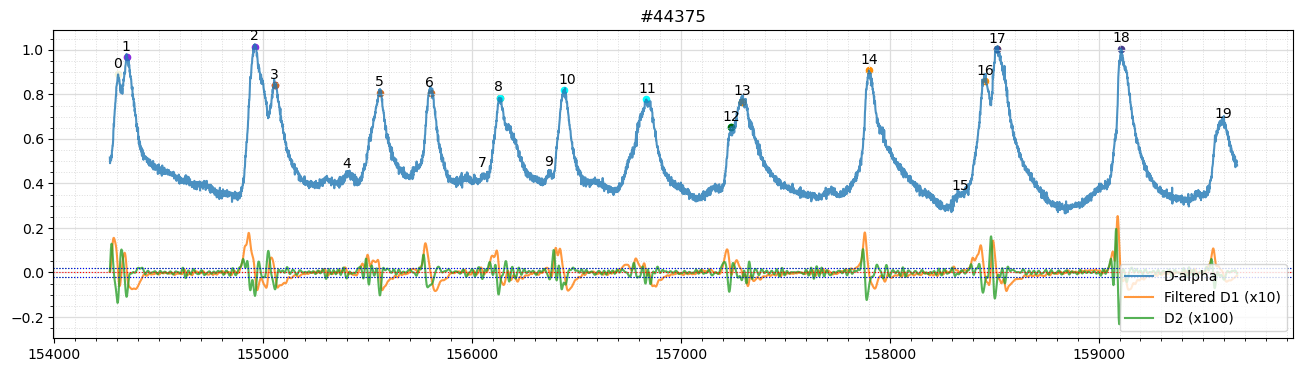

In [109]:
colors = list(COLORS.keys())

ind = 4
l_edge, r_edge = slices_edges[ind]

fig, ax1 = plt.subplots(nrows=1, sharex=True, gridspec_kw={'hspace': 0.2})

fig.set_figwidth(16)
fig.set_figheight(4)

ax1.set_title(f"#{F_ID}")

b, a = signal.butter(5, 0.1)
d_alpha_d2f = signal.filtfilt(b, a, np.diff(d_alpha_f))

ax1.plot(range(l_edge, r_edge), d_alpha[l_edge:r_edge], label="D-alpha", alpha=0.8, zorder=2)
# ax1.plot(range(l_edge, r_edge), d_alpha_d1[l_edge:r_edge], label="Diff 1")
ax1.plot(range(l_edge, r_edge), d_alpha_f[l_edge:r_edge] * 10, label="Filtered D1 (x10)", alpha=0.8)
ax1.plot(range(l_edge, r_edge), d_alpha_d2f[l_edge:r_edge] * 100, label="D2 (x100)", alpha=0.8)

# coef=1.
# x = get_d1_crosses(d_alpha_f, d_alpha_d2f, l_edge, r_edge, d1_coef=coef)
# print(f"{ind + 1}/{slices_edges.shape[0]} - Slice ({l_edge/1e3}, {r_edge/1e3}) ms - {len(x)} peaks - {(time.time() - start_time)*1e3:.3f} ms")
# ax1.scatter(x, d_alpha[x], s=20, color="black")

print(f"Start prossecing peaks ...")  # , end=" "
start_time = time.time()
res_groups_peaks = get_groups_from_signal(d_alpha, d_alpha_f, d_alpha_d2f, l_edge, r_edge)
print(f"- Tooks: {(time.time() - start_time)*1e3:.3f} ms")
for g_i in range(len(res_groups_peaks)):
    points = res_groups_peaks[g_i]
    c = colors[g_i * 5 + 5]
    ax1.scatter(points, d_alpha[points], s=20, color=c, zorder=0)
    m_d = (points[-1] - points[0]) / (len(points) - 1) / 1e3
    print(f"{g_i + 1}/{len(res_groups_peaks)} Group of peaks ({c}) - {len(points)} peaks in group - mean delta: {m_d:.3f} ms - freq: {1/m_d:.3f} kHz")

# peaks_groups = [[1, 2, 5, 8, 11, 13, 14, 17, 18], [0, 3, 6, 10, 12], [16, 19]]  # for slice (154.265, 159.664) ms - #44375
# p_c = ["red", "orange", "magenta"]  # , ""
# peaks_set = set()

# for g_i in range(len(peaks_groups)):
#     for i in peaks_groups[g_i]:
#         peaks_set.add(i)
#         ax1.scatter(x[i], d_alpha[x[i]], s=20, color=p_c[g_i])
#     m_d = (x[peaks_groups[g_i][-1]] - x[peaks_groups[g_i][0]]) / (len(peaks_groups[g_i]) - 1) / 1e3
#     print(f"{g_i + 1}/{len(peaks_groups)} Group of peaks - {len(peaks_groups[g_i])} peaks in group - mean delta: {m_d:.3f} ms - freq: {1/m_d:.3f} kHz")

# i = 0
# while i < len(x):
#     if i not in peaks_set:
#         ax1.scatter(x[i], d_alpha[x[i]], s=20, color="black")
#     i+=1        

for i in range(len(x)):
    num = i
    d = 0
    while num > 10:
        num = num // 10
        d += 1
    ax1.annotate(i, (x[i] - 25 - 15 * d, d_alpha[x[i]] + 0.03))

ax1.axhline(d_alpha_f.mean(), color="red", linestyle=':', linewidth=0.8)
ax1.axhline((d_alpha_f.mean() + d_alpha_f.std()) * 10 * coef, color="green", linestyle=':', linewidth=0.8)
ax1.axhline((d_alpha_f.mean() - d_alpha_f.std()) * 10 * coef, color="green", linestyle=':', linewidth=0.8)
ax1.axhline((d_alpha_d2f.mean() + d_alpha_d2f.std()) * 100, color="blue", linestyle=':', linewidth=0.8)
ax1.axhline((d_alpha_d2f.mean() - d_alpha_d2f.std()) * 100, color="blue", linestyle=':', linewidth=0.8)
ax1.grid(which='major', color='#DDDDDD', linewidth=0.9)
ax1.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
ax1.legend(loc='lower right')

plt.show()

# print("----")
# for j in range(len(slices_edges)):
#     print(f"{j + 1}/{slices_edges.shape[0]}")
#     l_edge, r_edge = slices_edges[j]
#     start_time = time.time()
#     res_groups = get_groups_from_signal(d_alpha, d_alpha_f, d_alpha_d2f, l_edge, r_edge)
#     print(f"Took: {(time.time() - start_time)*1e3:.3f} ms")

In [93]:
gr_delts = []
for d in sorted(res_groups.keys()):  # , key=lambda k: res_groups[k][0]
    delts = [d]
    for d2 in res_groups.keys():
        if abs(d - d2) / d <= 0.1 and d != d2 and len(res_groups[d2][0][1]) > 2 and d2 < 1000:
            delts.append(d2)
    if sorted(delts) not in gr_delts:
        gr_delts.append(sorted(delts))
        if len(res_groups[d][0][1]) > 2 and d < 1000:
            for x in sorted(delts, key=lambda k: len(res_groups[k][0][1]), reverse=True):
                print(f"{x}: {res_groups[x]}")
            print("----")

70: [[40.0, [0, 1, 2, 3, 4, 5]]]
65: [[37.0, [10, 11, 12, 13]]]
67: [[42.0, [3, 4, 5, 6]], [23.0, [12, 13, 14]]]
----
70: [[40.0, [0, 1, 2, 3, 4, 5]]]
67: [[42.0, [3, 4, 5, 6]], [23.0, [12, 13, 14]]]
65: [[37.0, [10, 11, 12, 13]]]
73: [[42.0, [23, 24, 25, 26]]]
----
70: [[40.0, [0, 1, 2, 3, 4, 5]]]
77: [[46.0, [6, 7, 8, 9, 10, 11]], [0.0, [30, 31]]]
67: [[42.0, [3, 4, 5, 6]], [23.0, [12, 13, 14]]]
65: [[37.0, [10, 11, 12, 13]]]
73: [[42.0, [23, 24, 25, 26]]]
----
70: [[40.0, [0, 1, 2, 3, 4, 5]]]
77: [[46.0, [6, 7, 8, 9, 10, 11]], [0.0, [30, 31]]]
80: [[29.0, [17, 18, 19, 20, 21, 22]]]
73: [[42.0, [23, 24, 25, 26]]]
67: [[42.0, [3, 4, 5, 6]], [23.0, [12, 13, 14]]]
78: [[39.0, [8, 9, 10, 11]], [0.0, [31, 32]]]
----
83: [[44.0, [2, 3, 4, 5, 6, 7, 8, 9]]]
77: [[46.0, [6, 7, 8, 9, 10, 11]], [0.0, [30, 31]]]
70: [[40.0, [0, 1, 2, 3, 4, 5]]]
80: [[29.0, [17, 18, 19, 20, 21, 22]]]
82: [[39.0, [27, 28, 29, 30, 31]]]
78: [[39.0, [8, 9, 10, 11]], [0.0, [31, 32]]]
73: [[42.0, [23, 24, 25, 26]]]
81

In [63]:
for d in sorted(res_groups.keys(), key=lambda k: res_groups[k][0]):
    if res_groups[d][1][:2] == [0, 3]:
        print(f"{d}: {res_groups[d]}")

751: [393.0, [0, 3, 6, 10, 12, 14, 17], False]


In [ ]:
for i in range(slices_edges.shape[0]):
    l_edge, r_edge = slices_edges[i]
    
    fig, ax1 = plt.subplots(nrows=1, sharex=True, gridspec_kw={'hspace': 0.2})

    fig.set_figwidth(16)
    fig.set_figheight(4)
    
    ax1.set_title(f"#{F_ID}")

    b, a = signal.butter(5, 0.1)
    d_alpha_d2f = signal.filtfilt(b, a, np.diff(d_alpha_f))

    ax1.plot(range(l_edge, r_edge), d_alpha[l_edge:r_edge], label="D-alpha", alpha=0.8)
    # ax1.plot(range(l_edge, r_edge), d_alpha_d1[l_edge:r_edge], label="Diff 1")
    ax1.plot(range(l_edge, r_edge), d_alpha_f[l_edge:r_edge] * 10, label="Filtered D1 (x10)", alpha=0.8)
    ax1.plot(range(l_edge, r_edge), d_alpha_d2f[l_edge:r_edge] * 100, label="D2 (x100)", alpha=0.8)

    coef=1.
    start_time = time.time()
    x = get_d1_crosses(d_alpha_f, d_alpha_d2f, l_edge, r_edge, d1_coef=coef)
    print(f"{i + 1}/{slices_edges.shape[0]} - Slice ({l_edge/1e3}, {r_edge/1e3}) ms - {len(x)} peaks - {(time.time() - start_time)*1e3:.3f} ms")
    ax1.scatter(x, d_alpha[x], s=20, color="black")

    # ax1.plot(range(l_edge, r_edge), mark_d_alpha_2[l_edge:r_edge] * 0.4, label="Mark (x0.4)", color="red")
    # ax1.plot(range(l_edge, r_edge), mark_d_alpha[l_edge:r_edge] * 0.5, label="Mark proc (x0.5)", color="black")
    ax1.axhline(d_alpha_f.mean(), color="red", linestyle=':', linewidth=0.8)
    ax1.axhline((d_alpha_f.mean() + d_alpha_f.std()) * 10 * coef, color="green", linestyle=':', linewidth=0.8)
    ax1.axhline((d_alpha_f.mean() - d_alpha_f.std()) * 10 * coef, color="green", linestyle=':', linewidth=0.8)
    ax1.axhline((d_alpha_d2f.mean() + d_alpha_d2f.std()) * 100, color="blue", linestyle=':', linewidth=0.8)
    ax1.axhline((d_alpha_d2f.mean() - d_alpha_d2f.std()) * 100, color="blue", linestyle=':', linewidth=0.8)
    # ax1.axhline((meta_da.d_q + meta_da.d_std * meta_da.d_std_bottom) * 10, color="green", linestyle=':', linewidth=0.8)
    # ax1.axhline((meta_da.d_q - meta_da.d_std * meta_da.d_std_bottom) * 10, color="green", linestyle=':', linewidth=0.8)
    # ax1.axhline((meta_da.d_q + meta_da.d_std * meta_da.d_std_top) * 10, color="blue", linestyle=':', linewidth=0.8)
    # ax1.axhline((meta_da.d_q - meta_da.d_std * meta_da.d_std_top) * 10, color="blue", linestyle=':', linewidth=0.8)
    ax1.grid(which='major', color='#DDDDDD', linewidth=0.9)
    ax1.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax1.legend()
    
    plt.savefig(proj_path + f"/img/d_alpha_peaks/{F_ID}_{i}.png")
    
    # print(get_groups_from_signal(d_alpha_f, d_alpha_d2f, l_edge, r_edge))



---
---

In [74]:
# demo for combine groups
groups = [[0, 1, 2, 3, 4, 5, 6], [4, 5, 6, 8, 11], [8, 11, 14]]

start_time = time.time()
k = check_subsequention(groups[0], groups[1])
print(f"Took: {(time.time() - start_time)*1e6:.3e} mcs")
print(f"Arrays: {groups[0]}, {groups[1]} - k = {k} - Res array: {groups[0] + groups[1][k:]}")

print("----")

start_time = time.time()
res_grops = combine_groups(groups)
print(f"Took: {(time.time() - start_time)*1e6:.3f} mcs")
print(res_grops)

Took: 0.000e+00 mcs
Arrays: [0, 1, 2, 3, 4, 5, 6], [4, 5, 6, 8, 11] - k = 3 - Res array: [0, 1, 2, 3, 4, 5, 6, 8, 11]
----
Took: 0.000 mcs
[[0, 1, 2, 3, 4, 5, 6], [4, 5, 6, 8, 11], [8, 11, 14], [0, 1, 2, 3, 4, 5, 6, 8, 11], [4, 5, 6, 8, 11, 14], [0, 1, 2, 3, 4, 5, 6, 8, 11, 14]]


In [ ]:
# non phisical
def get_groups_naive(arr): # -> groups = {Delta: [mistake: float, group: list]}
    n = len(arr)
    res = {}
    for i in range(n):
        for j in range(i + 1, n):
            delta = arr[j] - arr[i]
            group = [i, j]
            err = 0.0
            for k in range(j + 2, n):
                if abs(arr[k] - (arr[group[-1]] + delta)) >= abs(arr[k - 1] - (arr[group[-1]] + delta)):
                    cur_err = abs(arr[k - 1] - (arr[group[-1]] + delta)) - int(random.random() * 10)
                    if err + cur_err > delta / 3 * 2:  #  / len(group)
                        break
                    err += cur_err
                    group.append(k - 1)
            if delta in res.keys():
                res[delta].append([err, group])
                res[delta].sort(key=lambda x: len(x[1]), reverse=True)
            else:
                res[delta] = [[err, group]]
    return res

# def get_groups_dp(): # -> groups = {Delta: [mistake: float, group: list]}
# def get_groups_gen(): # -> groups = {Delta: [mistake: float, group: list]}

---
---

In [44]:
mgd = df.mgd_v.to_numpy() ** 2 + df.mgd_r.to_numpy() ** 2

In [45]:
meta_da = Signal_meta(chanel_name="da", processing_flag=True)
meta_da.set_statistics(d_alpha, d_alpha_f, 0.7, 0.7, d_std_bottom_edge=1.5, d_std_top_edge=2.7)
meta_da.set_edges(length_edge=15, distance_edge=30)

meta_da_2 = Signal_meta(chanel_name="da", processing_flag=False)
meta_da_2.set_statistics(d_alpha, d_alpha_f, 0.7, 0.7, d_std_bottom_edge=1.5, d_std_top_edge=2.5)
meta_da_2.set_edges(length_edge=15, distance_edge=30)

meta_sxr = Signal_meta(chanel_name="sxr", processing_flag=True)
meta_sxr.set_statistics(sxr, sxr_f, 0.8, 0.8, d_std_bottom_edge=7., d_std_top_edge=15.0)
meta_sxr.set_edges(length_edge=10, distance_edge=30, scale=0, step_out=20)

In [46]:
mark_data = np.zeros(d_alpha_f.shape)
mark_data[abs(d_alpha_f - meta_da.d_q) > meta_da.d_std * meta_da.d_std_bottom] = 1
mark_d_alpha = proc_slices(mark_data, d_alpha, d_alpha_f, meta_da)

mark_data = np.zeros(d_alpha_f.shape)
mark_data[abs(d_alpha_f - meta_da_2.d_q) > meta_da_2.d_std * meta_da_2.d_std_bottom] = 1
mark_d_alpha_2 = proc_slices(mark_data, d_alpha, d_alpha_f, meta_da_2)

mark_data = np.zeros(d_alpha_f.shape)
mark_data[abs(sxr_f - meta_sxr.d_q) > meta_sxr.d_std * meta_sxr.d_std_bottom] = 1
mark_sxr = proc_slices(mark_data, sxr, sxr_f, meta_sxr)

(184024, 184032)
(184744, 184753)
(185169, 185179)
(185274, 185283)
(185597, 185612)
(185721, 185733)
(185867, 185884)
(185909, 185941)
(185988, 186011)
(186053, 186066)
(186290, 186305)
(186359, 186378)
(186511, 186541)
(186970, 186981)
(187608, 187614)
(188330, 188336)
(188729, 188735)
(188749, 188757)


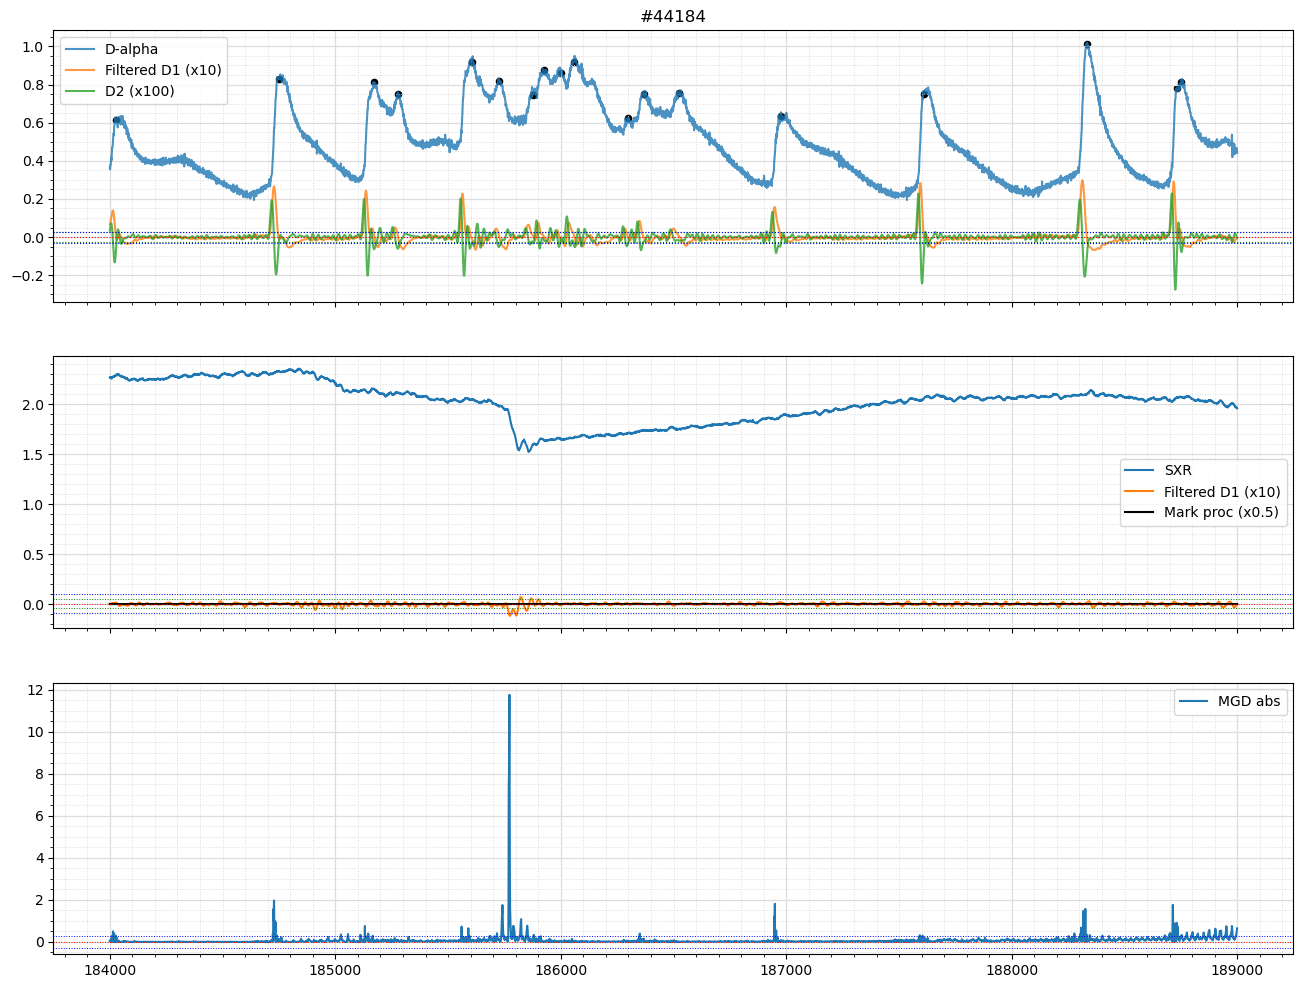

[[184014]
 [184019]
 [184723]
 [184725]
 [184726]
 [184727]
 [184728]
 [184729]
 [184733]
 [184734]
 [184735]
 [184741]
 [185025]
 [185056]
 [185111]
 [185112]
 [185131]
 [185146]
 [185560]
 [185589]
 [185590]
 [185591]
 [185717]
 [185736]
 [185737]
 [185738]
 [185739]
 [185740]
 [185741]
 [185742]
 [185743]
 [185744]
 [185745]
 [185768]
 [185769]
 [185770]
 [185771]
 [185772]
 [185773]
 [185774]
 [185775]
 [185776]
 [185777]
 [185778]
 [185779]
 [185787]
 [185788]
 [185789]
 [185790]
 [185791]
 [185792]
 [185793]
 [185794]
 [185795]
 [185820]
 [185821]
 [185822]
 [185823]
 [185824]
 [185825]
 [185848]
 [185849]
 [185850]
 [185851]
 [185852]
 [185853]
 [185880]
 [186350]
 [186946]
 [186947]
 [186948]
 [186949]
 [186950]
 [186955]
 [187592]
 [188277]
 [188278]
 [188303]
 [188307]
 [188311]
 [188313]
 [188314]
 [188316]
 [188317]
 [188318]
 [188325]
 [188326]
 [188332]
 [188345]
 [188346]
 [188678]
 [188679]
 [188698]
 [188699]
 [188700]
 [188701]
 [188702]
 [188703]
 [188704]
 [188713]


In [71]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


mode_plotting = 0  # int(input("Input visualising mode [ 0 - manual | 1 - only marked ]:"))
# mode_marking = int(input("Input marking mode (0 - manual | 1 - semiauto): ").strip().split()[0])
l_edge = 184000  # int(input(f"Input start index [0:{df.shape[0]//1000*1000}]: ").strip().split()[0])
# print("---")
step = 2000
width = 5000

step_away = 10

while l_edge < df.shape[0]:
    r_edge = min(l_edge + width, df.shape[0] - 1)
    
    if mode_plotting == 1 and sum(mark_d_alpha[l_edge:r_edge]) == 0 and sum(mark_sxr[l_edge:r_edge]) == 0:
        l_edge += step
        continue
    
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, sharex=True, gridspec_kw={'hspace': 0.2})

    fig.set_figwidth(16)
    fig.set_figheight(12)
    
    ax1.set_title(f"#{F_ID}")

    b, a = signal.butter(5, 0.1)
    d_alpha_d2f = signal.filtfilt(b, a, np.diff(d_alpha_f))

    ax1.plot(range(l_edge, r_edge), d_alpha[l_edge:r_edge], label="D-alpha", alpha=0.8)
    # ax1.plot(range(l_edge, r_edge), d_alpha_d1[l_edge:r_edge], label="Diff 1")
    ax1.plot(range(l_edge, r_edge), d_alpha_f[l_edge:r_edge] * 10, label="Filtered D1 (x10)", alpha=0.8)
    ax1.plot(range(l_edge, r_edge), d_alpha_d2f[l_edge:r_edge] * 100, label="D2 (x100)", alpha=0.8)

    x = get_d1_crosses(d_alpha_f, d_alpha_d2f, l_edge, r_edge)
    print(get_groups_from_signal(d_alpha_f, d_alpha_d2f, l_edge, r_edge))
    ax1.scatter(x, d_alpha[x], s=20, color="black")

    # ax1.plot(range(l_edge, r_edge), mark_d_alpha_2[l_edge:r_edge] * 0.4, label="Mark (x0.4)", color="red")
    # ax1.plot(range(l_edge, r_edge), mark_d_alpha[l_edge:r_edge] * 0.5, label="Mark proc (x0.5)", color="black")
    ax1.axhline(0, color="red", linestyle=':', linewidth=0.8)
    ax1.axhline((d_alpha_f.std()) * 10, color="green", linestyle=':', linewidth=0.8)
    ax1.axhline((- d_alpha_f.std()) * 10, color="green", linestyle=':', linewidth=0.8)
    ax1.axhline((np.diff(d_alpha_f).std()) * 100, color="blue", linestyle=':', linewidth=0.8)
    ax1.axhline((- np.diff(d_alpha_f).std()) * 100, color="blue", linestyle=':', linewidth=0.8)
    # ax1.axhline((meta_da.d_q + meta_da.d_std * meta_da.d_std_bottom) * 10, color="green", linestyle=':', linewidth=0.8)
    # ax1.axhline((meta_da.d_q - meta_da.d_std * meta_da.d_std_bottom) * 10, color="green", linestyle=':', linewidth=0.8)
    # ax1.axhline((meta_da.d_q + meta_da.d_std * meta_da.d_std_top) * 10, color="blue", linestyle=':', linewidth=0.8)
    # ax1.axhline((meta_da.d_q - meta_da.d_std * meta_da.d_std_top) * 10, color="blue", linestyle=':', linewidth=0.8)
    ax1.grid(which='major', color='#DDDDDD', linewidth=0.9)
    ax1.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax1.legend()

    ax2.plot(range(l_edge, r_edge), sxr[l_edge:r_edge], label="SXR")
    # ax2.plot(range(l_edge, r_edge), sxr_d1[l_edge:r_edge], label="Diff 1")
    ax2.plot(range(l_edge, r_edge), sxr_f[l_edge:r_edge] * 10, label="Filtered D1 (x10)")
    ax2.plot(range(l_edge, r_edge), mark_sxr[l_edge:r_edge] * 0.5, label="Mark proc (x0.5)", color="black")
    ax2.axhline(meta_sxr.d_q * 10, color="red", linestyle=':', linewidth=0.7)
    ax2.axhline((meta_sxr.d_q + meta_sxr.d_std * meta_sxr.d_std_bottom) * 10, color="green", linestyle=':', linewidth=0.7)
    ax2.axhline((meta_sxr.d_q - meta_sxr.d_std * meta_sxr.d_std_bottom) * 10, color="green", linestyle=':', linewidth=0.7)
    ax2.axhline((meta_sxr.d_q + meta_sxr.d_std * meta_sxr.d_std_top) * 10, color="blue", linestyle=':', linewidth=0.7)
    ax2.axhline((meta_sxr.d_q - meta_sxr.d_std * meta_sxr.d_std_top) * 10, color="blue", linestyle=':', linewidth=0.7)

    ax2.grid(which='major', color='#DDDDDD', linewidth=0.9)
    ax2.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    ax2.minorticks_on()
    ax2.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax2.legend()

    # mgd_filtered = np.copy(mgd)
    # mgd_filtered[abs(mgd_filtered - mgd.mean()) > 5 * mgd.std()] = mgd.mean()
    
    b, a = signal.butter(5, 0.2)
    mgd_f = signal.filtfilt(b, a, mgd)

    # mgd_d1 = np.diff(mgd_f)
    # mgd_ff = signal.filtfilt(b, a, mgd_d1)

    mgd_f_filtered = np.copy(mgd_f)
    mgd_f_filtered[abs(mgd_f_filtered - mgd_f.mean()) > 5 * mgd_f.std()] = mgd_f.mean()

    mgd_f_d1 = np.diff(mgd_f)
    
    ax3.plot(range(l_edge, r_edge), mgd[l_edge:r_edge], label="MGD abs")  # semilogy np.diff(sxr)
    # ax3.plot(range(l_edge, r_edge), mgd_f_d1[l_edge:r_edge], label="Filtered D1 (x10)")  # semilogy np.diff(sxr)
    # ax3.plot(range(l_edge, r_edge), mgd_f_filtered[l_edge:r_edge], label="Filtered MGD")  # semilogy np.diff(sxr)
    ax3.axhline(mgd_f.mean(), color="red", linestyle=':', linewidth=0.7)
    # ax3.axhline(mgd_ff.mean(), color="red", linestyle=':', linewidth=0.7)
    # ax3.axhline((mgd_ff.mean() + 1 * mgd_f_filtered.std()) * 1, color="green", linestyle=':', linewidth=0.7)
    # ax3.axhline((mgd_ff.mean() - 1 * mgd_f_filtered.std()) * 1, color="green", linestyle=':', linewidth=0.7)
    ax3.axhline((mgd_f.mean() + 1 * mgd.std()) * 1, color="blue", linestyle=':', linewidth=0.7)
    ax3.axhline((mgd_f.mean() - 1 * mgd.std()) * 1, color="blue", linestyle=':', linewidth=0.7)
    ax3.legend()

    ax3.grid(which='major', color='#DDDDDD', linewidth=0.9)
    ax3.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    ax3.minorticks_on()
    ax3.xaxis.set_minor_locator(AutoMinorLocator(10))
    
    plt.show()

    # res = list(map(int, input(f"Input index pairs of ELM fragments ({df.t[l_edge]} - {df.t[r_edge]} ms):\n").strip().split()))
    # for i in range(0, len(res), 2):
    #     board_ind = [res[i], res[i+1]]

    #     mark = float(input("Input mark to set [ 0 | 1 | 2 ]: "))
        
    #     if mode_marking and mark > 0:
    #         board_ind = get_borders(df.loc[res[i]:res[i + 1], "ch1"].to_numpy(), scale=1.5)
    #         board_ind[0] = max(board_ind[0] - step_away + res[i], 0)
    #         board_ind[1] += res[i]
        
    #     df.loc[board_ind[0]:board_ind[1], "ch1_marked"] = mark

    print(np.argwhere(abs(mgd[l_edge: r_edge] - mgd.mean()) >  mgd.std()) + l_edge)

    print(f"ELM fragment ({df.t[l_edge]} - {df.t[r_edge]} ms)\n")
    break
    # input(f"ELM fragment ({df.t[l_edge]} - {df.t[r_edge]} ms)\n")

    plt.close()
    plt.clf()
    l_edge += step

# 217500

---
### Reporting sync ELM program
---

In [89]:
filename = f"{F_ID}"

sxr_slices = [Slice(0, 0)] + get_slices(mark_sxr)
deltas_sync_elm = np.full(shape=len(sxr_slices), fill_value=np.nan)
count_desync_elm = np.full(shape=len(sxr_slices), fill_value=np.nan)
deltas_desync_elm = np.full(shape=len(sxr_slices), fill_value=np.nan)
amplitudes_sync_mgd = np.full(shape=len(sxr_slices), fill_value=np.nan)
deltas_sync_mgd = np.full(shape=len(sxr_slices), fill_value=np.nan)
amplitudes_desync_mgd = np.full(shape=len(sxr_slices), fill_value=np.nan)
deltas_desync_mgd = np.full(shape=len(sxr_slices), fill_value=np.nan)

report_lines = []

report_lines.append("\n----------------\n")
report_lines.append(f"Signal {filename}\n")
report_lines.append(f"SXR falls: {len(sxr_slices) - 1}\n")
report_lines.append("-----\n")
l_shift, r_shift = 100, 1500
# logg 6
print("-", end="")

for sl_i in range(1, len(sxr_slices)):
    sxr_pointer = np.argmin(sxr_f[sxr_slices[sl_i].l: sxr_slices[sl_i].r]) + sxr_slices[sl_i].l
    
    da_slices = get_slices(mark_d_alpha[sxr_slices[sl_i - 1].r: min(sxr_slices[sl_i].r + r_shift, mark_d_alpha.shape[0])])
    mgd_slice = sxr_slices[sl_i].copy()
    mgd_slice.expand(l_shift)

    deltas_sync_mgd[sl_i - 1] = (np.argmax(mgd[mgd_slice.l: mgd_slice.r]) + mgd_slice.l - sxr_pointer) / 1e3
    amplitudes_sync_mgd[sl_i - 1] = abs(mgd[mgd_slice.l: mgd_slice.r].max() - mgd.mean())
    
    if deltas_sync_mgd[sl_i - 1] >= 0.5:
        deltas_sync_mgd[sl_i - 1] = np.nan
        sync_mgd_info = f"-- No nearest peaks on MGD"
    else:
        sync_mgd_info = f"-- MGD peak: delta = {deltas_sync_mgd[sl_i - 1]:3.3f} ms, amplitude = {amplitudes_sync_mgd[sl_i - 1]:3.3f}"

    if len(da_slices) == 0:
        deltas_sync_elm[sl_i - 1] = np.nan
        sync_elm_info = f"-- No sync ELM on D-alpha"
        desync_elm_info = f"-- No desync ELM on D-alpha"  # + " " * 15
    else:
        ind = 0
        while sxr_slices[sl_i].r - (da_slices[ind].r + sxr_slices[sl_i - 1].l - l_shift) > 0 and ind + 1 < len(da_slices):
            ind += 1

        sync_elm_slice = da_slices[ind].copy()
        sync_elm_slice.move(sxr_slices[sl_i - 1].l)
        deltas_sync_elm[sl_i - 1] = (np.argmax(d_alpha_f[sync_elm_slice.l: sync_elm_slice.r]) + sync_elm_slice.l - sxr_pointer) / 1e3
        
        if deltas_sync_elm[sl_i - 1] >= 0.5:  #  or deltas_sync_elm[sl_i] < - l_shift / 1e3
            deltas_sync_elm[sl_i - 1] = np.nan
            sync_elm_info = f"-- No sync ELM on D-alpha"
        else:
            sync_elm_info = f"-- Sync ELM: d = {deltas_sync_elm[sl_i - 1]:3.3f} ms"

        if ind - 1 <= 0:
            count_desync_elm[sl_i - 1] = np.nan
            desync_elm_info = f"-- No desync ELM on D-alpha"  # + " " * 15
            desync_mgd_info = ""
        else:
            count_desync_elm[sl_i - 1] = ind - 1
            
            cur_deltas_desync_elm = np.zeros(int(count_desync_elm[sl_i - 1] - 1))
            cur_desync_mgd_amplitude = np.zeros(int(count_desync_elm[sl_i - 1]))
            cur_desync_mgd_deltas = np.zeros(int(count_desync_elm[sl_i - 1]))

            prev_argmax = np.argmax(d_alpha_f[da_slices[1].l: da_slices[1].r]) + da_slices[1].l
            
            cur_desync_mgd_amplitude[0] = abs(mgd[da_slices[1].l - 10: da_slices[1].r + 10].max() - mgd.mean())
            cur_desync_mgd_deltas[0] = (np.argmax(mgd[da_slices[1].l - 10: da_slices[1].r + 10]) + da_slices[1].l - 10 - prev_argmax) / 1e3
            
            for elm_ind in range(1, ind - 1):
                cur_argmax = np.argmax(d_alpha_f[da_slices[elm_ind].l: da_slices[elm_ind].r]) + da_slices[elm_ind].l
                cur_deltas_desync_elm[elm_ind - 1] = (cur_argmax - prev_argmax) / 1e3
                
                cur_desync_mgd_amplitude[elm_ind] = abs(mgd[da_slices[elm_ind].l - 100: da_slices[elm_ind].r + 100].max() - mgd.mean())
                cur_desync_mgd_deltas[elm_ind] = (np.argmax(mgd[da_slices[elm_ind].l - 100: da_slices[elm_ind].r + 100]) + da_slices[elm_ind].l - 100 - cur_argmax) / 1e3
                
                prev_argmax = cur_argmax

            deltas_desync_elm[sl_i - 1] = cur_deltas_desync_elm.mean() if count_desync_elm[sl_i - 1] - 1 > 0 else np.nan
            amplitudes_desync_mgd[sl_i - 1] = np.nanmean(cur_desync_mgd_amplitude)
            deltas_desync_mgd[sl_i - 1] = np.nanmean(cur_desync_mgd_deltas)
            desync_elm_info = f"-- Desync ELM: count = {count_desync_elm[sl_i - 1]}"
            if count_desync_elm[sl_i - 1] > 1 and cur_deltas_desync_elm.mean() > 1e-6:
                desync_elm_info += f", fr mean = {1 / cur_deltas_desync_elm.mean():3.3f} kGz, fr std = {cur_deltas_desync_elm.std() / (cur_deltas_desync_elm.mean() ** 2):3.3f} kGz"  # d mean = {desync_elm_deltas.mean():3.3f}, d std = {desync_elm_deltas.std():3.3f} ms, 
            else:
                desync_elm_info += f", fr mean = nan kGz, fr std = nan kGz"
            desync_mgd_info = f"-- MGD peaks: deltas mean = {cur_desync_mgd_deltas.mean():3.3f} ms, deltas std = {cur_desync_mgd_deltas.std():3.3f} ms, "
            desync_mgd_info += f"A mean = {cur_desync_mgd_amplitude.mean():6.6f}, A std = {cur_desync_mgd_amplitude.std():6.6f}"
        
    
    report_lines.append(f"{sl_i}. SXR fall - {sxr_pointer / 1e3:3.3f} ms {sync_elm_info}\n\t{sync_mgd_info}\n\t{desync_elm_info}\n\t{desync_mgd_info}\n")
# logg 8
print("-", end="")


report_lines.append("-----\n")
report_lines.append(f"Sync ELM info: deltas mean = {np.nanmean(deltas_sync_elm):.3f} ms, deltas std = {np.nanstd(deltas_sync_elm):.3f} ms\n")
report_lines.append(f"Desync ELM info: count mean = {np.nanmean(count_desync_elm):.3f}, count std = {np.nanstd(count_desync_elm):.3f}, " +
                    f"frequency mean = {1 / np.nanmean(deltas_desync_elm):.3f} ms, frequency std = {np.nanstd(deltas_desync_elm) / (np.nanmean(deltas_desync_elm) ** 2):.3f}\n")
report_lines.append(f"MGD peaks info (sync ELM): deltas mean = {np.nanmean(deltas_sync_mgd):.3f} ms, deltas std = {np.nanstd(deltas_sync_mgd):.3f} ms, " +
                    f"A mean = {np.nanmean(amplitudes_sync_mgd):.3f}, A std = {np.nanstd(amplitudes_sync_mgd):.3f}\n")
report_lines.append(f"MGD peaks info (desync ELM): deltas mean = {np.nanmean(deltas_desync_mgd):.3f} ms, " +
                    f"A mean = {np.nanmean(amplitudes_desync_mgd):.3f}\n")
report_lines.append("-----\n")
report_lines.append(f"SXR falls w/o sync ELM in nearest area (-{l_shift * 1e-3} ms; {r_shift * 1e-3} ms): {np.count_nonzero(np.isnan(deltas_sync_elm))}\n")
report_lines.append(f"SXR falls w/o peaks on MGD in nearest area (-{l_shift * 1e-3} ms; {l_shift * 1e-3} ms): {np.count_nonzero(np.isnan(deltas_sync_mgd))}\n")
report_lines.append("-----\n")
report_lines.append(f"SXR signal info: diff_quantile = {meta_sxr.d_q:.6f}, diff_std = {meta_sxr.d_std:.6f}\n")
report_lines.append(f"MGD signal info: mean = {mgd.mean():.6f}, std = {mgd.std():.6f}\n")
report_lines.append("-----\n")
report_lines.append(f"SXR diff_std_top_edge: {meta_sxr.d_std_bottom:.3f} (approximate w/ a*exp^b)\n")
report_lines.append("----------------\n")
# logg 9
print("-", end="")

print("".join(report_lines))

---
----------------
Signal 44184
SXR falls: 24
-----
1. SXR fall - 175.998 ms -- No sync ELM on D-alpha
	-- MGD peak: delta = 0.000 ms, amplitude = 0.178
	-- Desync ELM: count = 80.0, fr mean = 2.519 kGz, fr std = 2.251 kGz
	-- MGD peaks: deltas mean = 0.021 ms, deltas std = 0.089 ms, A mean = 0.891379, A std = 1.231695
2. SXR fall - 185.792 ms -- No sync ELM on D-alpha
	-- MGD peak: delta = -0.020 ms, amplitude = 11.735
	-- Desync ELM: count = 11.0, fr mean = 1.323 kGz, fr std = 1.215 kGz
	-- MGD peaks: deltas mean = -0.011 ms, deltas std = 0.101 ms, A mean = 0.016580, A std = 0.000082
3. SXR fall - 189.237 ms -- Sync ELM: d = 0.406 ms
	-- MGD peak: delta = -0.015 ms, amplitude = 34.280
	-- Desync ELM: count = 4.0, fr mean = 2.627 kGz, fr std = 2.119 kGz
	-- MGD peaks: deltas mean = -0.025 ms, deltas std = 0.105 ms, A mean = 0.016625, A std = 0.000019
4. SXR fall - 193.060 ms -- No sync ELM on D-alpha
	-- MGD peak: delta = -0.005 ms, amplitude = 17.076
	-- Desync ELM: count = 8.0, fr

In [115]:
def process_fragments(data: np.array, mark_data: np.array, length_edge=10, distance_edge=25, scale=1.5, step_out=10) -> np.array:
    proc_slice = Slice(0, 0)
    cur_slice = Slice(0, 1)
    f_fragment = False

    while cur_slice.r < mark_data.shape[0]:
        if mark_data[cur_slice.r] == 1.0:
            if not f_fragment:
                f_fragment = True
        elif f_fragment:
            # print(start_ind, end_ind)
            if scale <= 1:
                if not cur_slice.check_length(length_edge):
                    mark_data[cur_slice.l: cur_slice.r] = 0.0
                elif not proc_slice.collide_slices(cur_slice, distance_edge):
                    mark_data[proc_slice.l: proc_slice.r] = 1.0
                    proc_slice.copy(cur_slice)
            elif scale:
                mark_data[cur_slice.l: cur_slice.r] = 0.0
                if cur_slice.check_length(length_edge):
                    boarders = get_boarders(data[cur_slice.l: cur_slice.r], scale)
                    # print(boards)
                    boarders[0] = max(boarders[0] + cur_slice.l - step_out, 0)
                    boarders[1] = min(boarders[1] + cur_slice.l, mark_data.shape[0])

                    mark_data[boarders[0]:boarders[1]] = 1.0

            f_fragment = False
            cur_slice.collapse_borders()
        elif not f_fragment:
            cur_slice.collapse_borders()
            if proc_slice.is_null():
                proc_slice.copy(cur_slice)

        cur_slice.step()

    return mark_data